In [1]:
import numpy as np
from pathlib import Path

import os, yaml
from utils import load_data, standardize, collate_fn
from stnp import STNP
import torch
#
from utils import load_data, FeatureDataset, load_graph_data
import matplotlib.pyplot as plt
import pickle, glob
from functools import partial

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
params= yaml.load(open("config.yaml", "r"), Loader= yaml.SafeLoader)

In [3]:
def get_tensor(xx, yy):
    x= torch.tensor(xx).float()
    y= torch.tensor(yy).float().permute(1, 0, 2)
    return x, y[1:,...], y[0,...]
#
def load_model(x, y, model, checkpoint_path):
    x, y, y0= get_tensor(x, y)
    y_pred= model.generate(x, y0)
    checkpoint= torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])
    return model
#
def get_sample_predictions(model, x_filenames, y_inc_filenames, y_prev_filenames, file_id, id2features:dict, n_samples):
    
    x_filename= x_filenames[file_id]
    y_inc_filename= y_inc_filenames[file_id]
    y_prev_filename= y_prev_filenames[file_id]
    
    feature=id2features[os.path.basename(x_filename).split("_")[0]]
    
    x= np.load(x_filename)
    y_inc= np.load(y_inc_filename)
    y_prev= np.load(y_prev_filename)
    
    y= np.concatenate([y_inc, y_prev], axis=-1)
    
    y0=y[:, 0,...]
    
    xin=x[5]
    
    samples=[]
    for i in range(25):
        samples.append(model.get_samples(xin, y0[i] , 1))
    
    samples= np.concatenate(samples, axis=0)
    # samples= model.get_samples(xin, y0 , n_samples)
    
    return samples, y[:,1:,...], feature
#
x_filenames, y_inc_filenames, y_prev_filenames= load_data(params["dataPath"], "val")
edge_index, edge_weight= load_graph_data(params["dataPath"])

x= np.load(x_filenames[0])
y_inc= np.load(y_inc_filenames[0])
y_prev= np.load(y_prev_filenames[0])
y= np.concatenate([y_inc, y_prev], axis=-1)

model= STNP(edge_index, edge_weight, params)
checkpoint_path= "./logs/checkpoints/checkpoint_iter_49.pt"
model= load_model(x, y, model, checkpoint_path)
#

In [4]:
def load_info(path):
    with open(os.path.join(path, "state_map.pk"), "rb") as fp:
        id2states= pickle.load(fp)
    with open(os.path.join(path, "id2features.pk"), "rb") as fp:
        id2features= pickle.load(fp)
    return id2states, dict(id2features)

In [5]:
id2states, id2features= load_info(params["dataPath"])

In [6]:
stats= np.load(os.path.join(params["dataPath"], "stats.npz"))
        
x_mean, x_std, y_inc_mean, y_inc_std, y_prev_mean, y_prev_std= stats["x_mean"], stats["x_std"], stats["y_inc_mean"], stats["y_inc_std"], stats["y_prev_mean"], stats["y_prev_std"]

In [7]:
x_filenames, y_inc_filenames, y_prev_filenames= [], [], []
for category in ["train", "val", "test"]:
    xf, yif, ypf= load_data(params["dataPath"], category)
    x_filenames.extend(xf)
    y_inc_filenames.extend(yif)
    y_prev_filenames.extend(ypf)

In [8]:
def get_dataset(x_filenames, y_inc_filenames, y_prev_filenames):

    stats= np.load(os.path.join(params["dataPath"], "stats.npz"))
   
    x_mean, x_std, y_inc_mean, y_inc_std, y_prev_mean, y_prev_std= stats["x_mean"], stats["x_std"], stats["y_inc_mean"], stats["y_inc_std"], stats["y_prev_mean"], stats["y_prev_std"] 

    x_transform = partial(standardize, mean= x_mean, std= x_std)
    y_inc_transform = partial(standardize, mean= y_inc_mean, std= y_inc_std)
    y_prev_transform = partial(standardize, mean= y_prev_mean, std= y_prev_std)

    dataset= FeatureDataset(x_filenames, y_inc_filenames, y_prev_filenames, x_transform, y_inc_transform, y_prev_transform)

    return dataset

In [9]:
def get_sample_data(model, x_filenames, y_inc_filenames, y_prev_filenames, state_id):
    
    data_stats= np.load(os.path.join(params["dataPath"], "stats.npz"))

    x_mean, x_std, y_inc_mean, y_inc_std, y_prev_mean, y_prev_std= stats["x_mean"], stats["x_std"], stats["y_inc_mean"], stats["y_inc_std"], stats["y_prev_mean"], stats["y_prev_std"]
    
    

    y_mean= np.concatenate([y_inc_mean, y_prev_mean], axis=-1)
    y_std= np.concatenate([y_inc_std, y_prev_std], axis=-1)

    y_std[y_std==0]=1.0
    
    batch_size=10

    dataset= get_dataset(x_filenames, y_inc_filenames, y_prev_filenames)

    loader= torch.utils.data.DataLoader(dataset, batch_size= batch_size, collate_fn=collate_fn)

    inc_infected_samples= []
    inc_recovered_samples=[]

    prev_infected_samples= []
    prev_recovered_samples=[]

    samples=[]

    for batch in loader:
        
        x, y, y0= batch
        
        
        y_pred=model.generate(x, y0).permute(1, 0, 2)

        samples.append(y_pred.detach().cpu().numpy())
    

    #
    samples=y_mean+ y_std*np.concatenate(samples, axis=0)
    samples[samples<0.0]=0.0


    inc_infected_samples.append(samples[..., state_id])
    inc_recovered_samples.append(samples[..., state_id+51])

    prev_infected_samples.append(samples[..., state_id+51*2])
    prev_recovered_samples.append(samples[..., state_id*3])
    
    #
    return np.vstack(inc_infected_samples), np.vstack(inc_recovered_samples), np.vstack(prev_infected_samples), np.vstack(prev_recovered_samples)
        

In [10]:
def get_files_with_R0(x_filenames, y_inc_filenames, y_prev_filenames, R0_range:list, seasonality_range:list, initial_immunity_range:list, id2features:dict):
    
    
    x_files=[]
    inc_files=[]
    prev_files=[]
    
    for x_filename, inc_filename, prev_filename in zip(x_filenames, y_inc_filenames, y_prev_filenames):
        fid= os.path.basename(inc_filename).split("_")[0]
        
        imm, seasonality, R0= id2features[str(fid)]
        
        if R0_range[0] <= R0 <= R0_range[1]  and seasonality_range[0]<=seasonality<=seasonality_range[1] and initial_immunity_range[0]<= imm<= initial_immunity_range[1]:
            x_files.append(x_filename)
            inc_files.append(inc_filename)
            prev_files.append(prev_filename)
    
    return x_files, inc_files, prev_files

In [11]:
def get_state_data(inc_files, prev_files, state_id):
    
    inc_infected_data= []
    inc_recovered_data=[]
    
    prev_infected_data= []
    prev_recovered_data=[]
    
    for file_inc, file_prev in zip(inc_files, prev_files):
        y_inc= np.load(file_inc)
        y_prev= np.load(file_prev)
        
        inc_infected_data.append(y_inc[..., state_id])
        inc_recovered_data.append(y_inc[..., state_id+51])
        
        prev_infected_data.append(y_prev[..., state_id])
        prev_recovered_data.append(y_prev[..., state_id+51])
        
    return np.vstack(inc_infected_data), np.vstack(inc_recovered_data), np.vstack(prev_infected_data), np.vstack(prev_recovered_data)

In [12]:
def plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles):
    fig, ax= plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
    #####
    _=ax[0, 0].plot(np.median(inc_infected_data, axis=0), label="true median")
    q05, q95= np.quantile(inc_infected_data, axis=0, q=quantiles)
    _= ax[0, 0].fill_between(x= range(inc_infected_data.shape[1]), y1=q05, y2= q95, alpha=.2)
    #
    _=ax[0, 0].plot(np.median(inc_infected_samples, axis=0), label="sample median", color="orange")
    q05, q95= np.quantile(inc_infected_samples, axis=0, q=quantiles)
    _= ax[0, 0].fill_between(x= range(inc_infected_samples.shape[1]), y1=q05, y2= q95, alpha=.2, color="orange")
    # #
    ax[0, 0].set_ylabel("individuals/100K")
    ax[0, 0].set_title("incidence infected")

    ########
    _=ax[0,1].plot(np.median(inc_recovered_data, axis=0), label="true median")
    q05, q95= np.quantile(inc_recovered_data, axis=0, q=quantiles)
    _= ax[0,1].fill_between(x= range(inc_recovered_data.shape[1]), y1=q05, y2= q95, alpha=.2)
    #
    _=ax[0,1].plot(np.median(inc_recovered_samples, axis=0), label="sampls median", color="orange")
    q05, q95= np.quantile(inc_recovered_samples, axis=0, q=quantiles)
    _= ax[0,1].fill_between(x= range(inc_recovered_samples.shape[1]), y1=q05, y2= q95, alpha=.2, color="orange")
    #
    #
    ax[0, 1].set_title("incidence recovered")
    ax[0, 1].legend()
    ##########
    _=ax[1,0].plot(np.median(prev_infected_data, axis=0), label="true median")
    q05, q95= np.quantile(prev_infected_data, axis=0, q=quantiles)
    _= ax[1,0].fill_between(x= range(prev_infected_data.shape[1]), y1=q05, y2= q95, alpha=.2)
    #
    _=ax[1,0].plot(np.median(prev_infected_samples, axis=0), label="sample median", color="orange")
    q05, q95= np.quantile(prev_infected_samples, axis=0, q=quantiles)
    _= ax[1,0].fill_between(x= range(prev_infected_samples.shape[1]), y1=q05, y2= q95, alpha=.2, color="orange")

    #
    ax[1,0].set_title("prevalence infected")
    ax[1, 0].set_ylabel("individuals/100K")
    ax[1, 0].set_xlabel("Days")
    #########
    prev_recovered_data= np.cumsum(inc_recovered_data, axis=-1)
    _=ax[1,1].plot(np.median(prev_recovered_data, axis=0), label="true median")
    q05, q95= np.quantile(prev_recovered_data, axis=0, q=quantiles)
    _= ax[1,1].fill_between(x= range(prev_recovered_data.shape[1]), y1=q05, y2= q95, alpha=.2)
    #
    p_rec= np.cumsum(inc_recovered_samples, axis=-1)
    _=ax[1,1].plot(np.median(p_rec, axis=0), label="sample median", color="orange")
    q05, q95= np.quantile(p_rec, axis=0, q=quantiles)
    _= ax[1,1].fill_between(x= range(prev_recovered_samples.shape[1]), y1=q05, y2= q95, alpha=.2, color="orange")
    #
    #
    ax[1,1].set_xlabel("Days")
    ax[1, 1].set_title("prevalence recovered")
    #
    #
    

In [91]:
state_id=4
r0_range, seasonality_range, frac_suceptibility_range= [1.9, 2.2], [.65, .75], [.4, .6]

In [92]:
x_files, inc_files, prev_files= get_files_with_R0(x_filenames, y_inc_filenames, y_prev_filenames, r0_range, seasonality_range, frac_suceptibility_range, id2features)

In [93]:
inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data= get_state_data(inc_files, prev_files, state_id=state_id)

In [94]:
print(len(x_files))

60


In [95]:
%%time
inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples= get_sample_data(model, x_files, inc_files, prev_files, state_id)

CPU times: user 1min 9s, sys: 55.6 s, total: 2min 4s
Wall time: 48 s


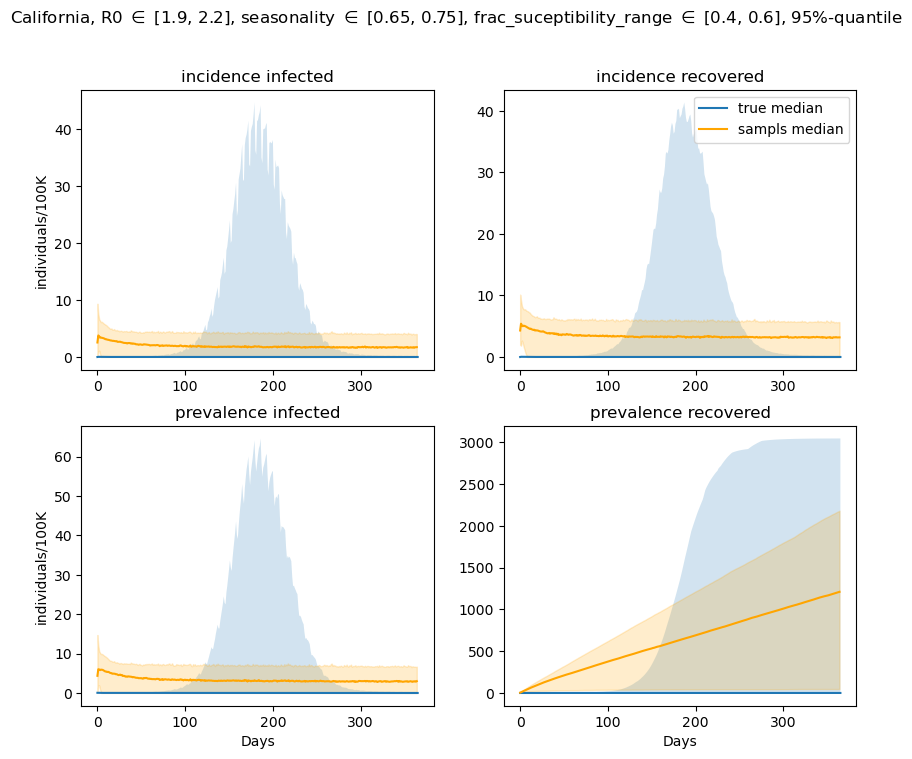

In [96]:
quantiles=[.02, .98]
quantile_name="95%"
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantile_name}-quantile")
plt.savefig("./figs/qunatile.jpg", dpi=300)

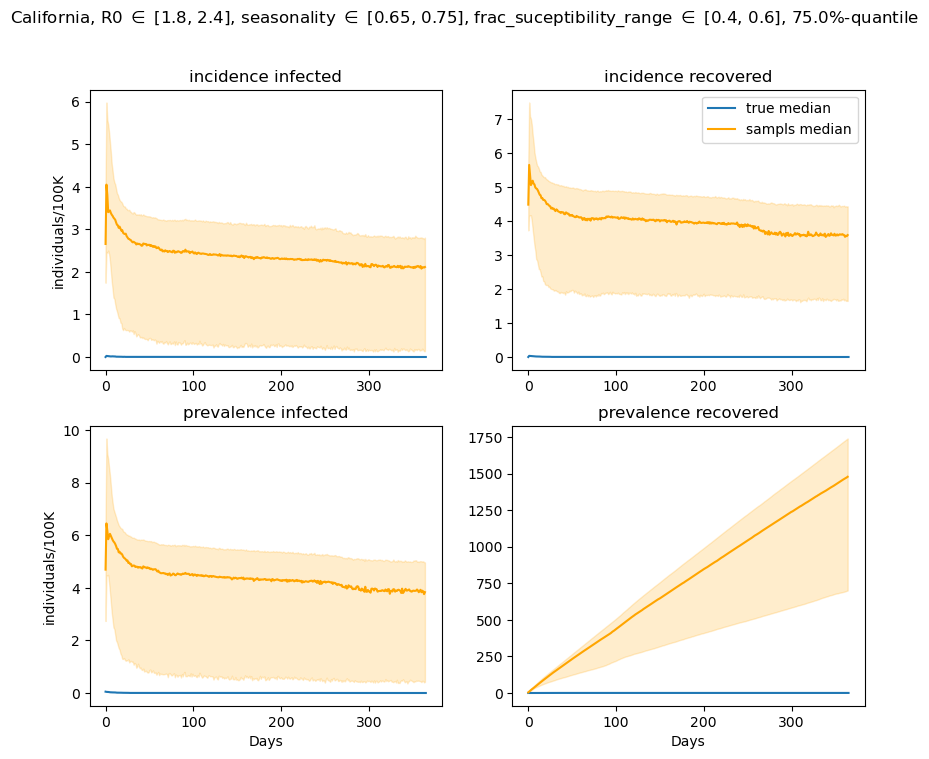

In [60]:
quantiles=[.125, .75]
quantile_name="75%"
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantile_name}-quantile")
plt.savefig("./figs/quantile_2.jpg", dpi=300)

In [115]:
state_id=4
r0_range, seasonality_range, frac_suceptibility_range= [2, 2.2], [.75, .85], [.3, .4]
x_files, inc_files, prev_files= get_files_with_R0(x_filenames, y_inc_filenames, y_prev_filenames, r0_range, seasonality_range, frac_suceptibility_range, id2features)
inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data= get_state_data(inc_files, prev_files, state_id=state_id)
print(len(x_files))

9


In [116]:
%%time
inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples= get_sample_data(model, x_files, inc_files, prev_files, state_id)

CPU times: user 10.5 s, sys: 7.11 s, total: 17.6 s
Wall time: 6.46 s


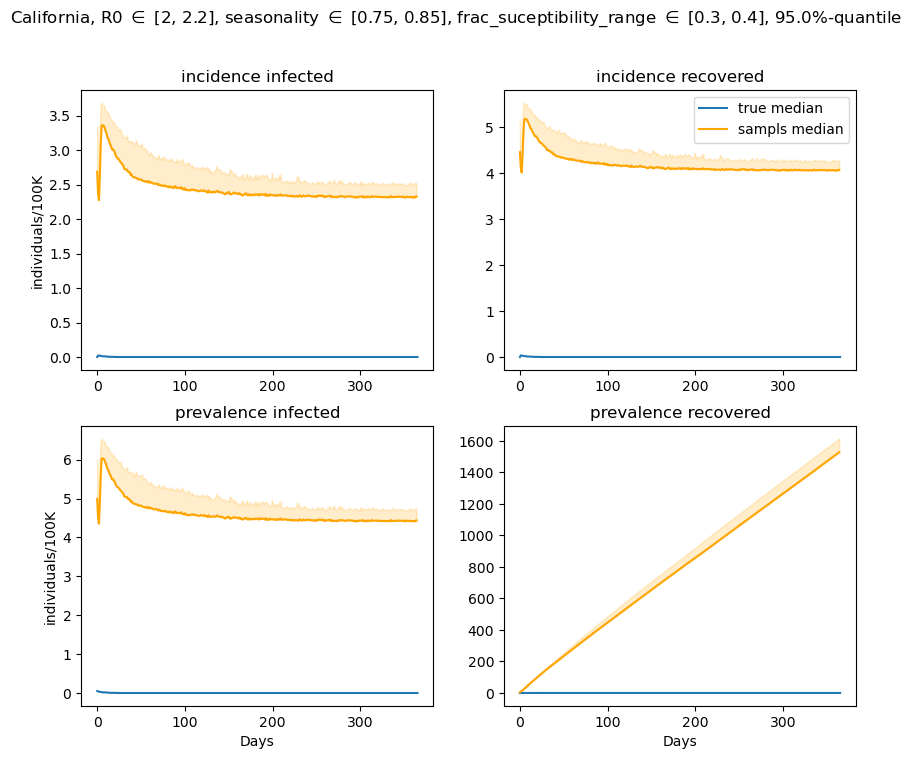

In [82]:
quantiles=[.5, .95]
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantiles[-1]*100}%-quantile")

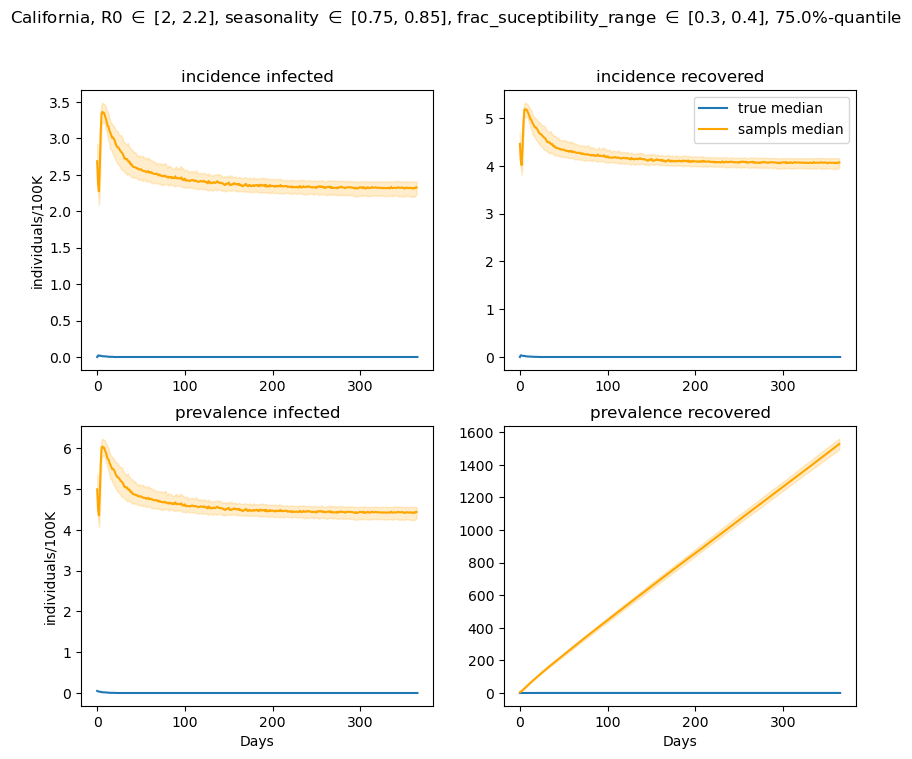

In [83]:
quantiles=[.25, .75]
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantiles[-1]*100}%-quantile")

In [84]:
state_id=4
r0_range, seasonality_range, frac_suceptibility_range= [1.6, 1.8], [.75, .85], [.3, .4]
x_files, inc_files, prev_files= get_files_with_R0(x_filenames, y_inc_filenames, y_prev_filenames, r0_range, seasonality_range, frac_suceptibility_range, id2features)
inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data= get_state_data(inc_files, prev_files, state_id=state_id)
print(len(x_files))

9


In [85]:
%%time
inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples= get_sample_data(model, x_files, inc_files, prev_files, state_id)

CPU times: user 10.7 s, sys: 6.54 s, total: 17.3 s
Wall time: 6.58 s


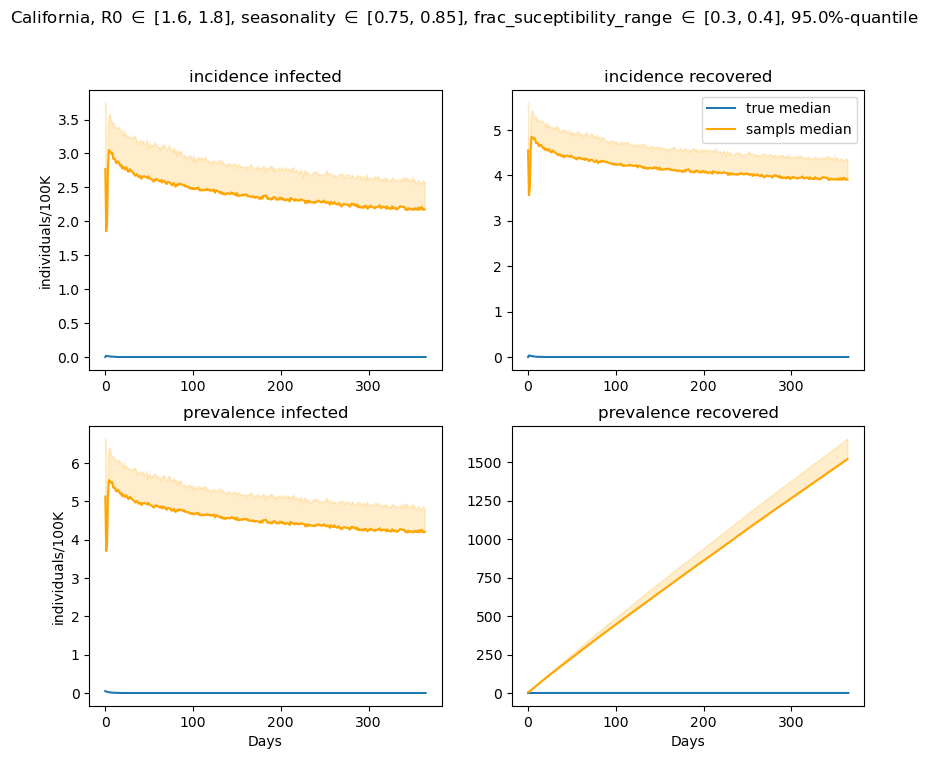

In [86]:
quantiles=[.5, .95]
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantiles[-1]*100}%-quantile")
plt.savefig("./figs/quantile_3.jpg", dpi=300)

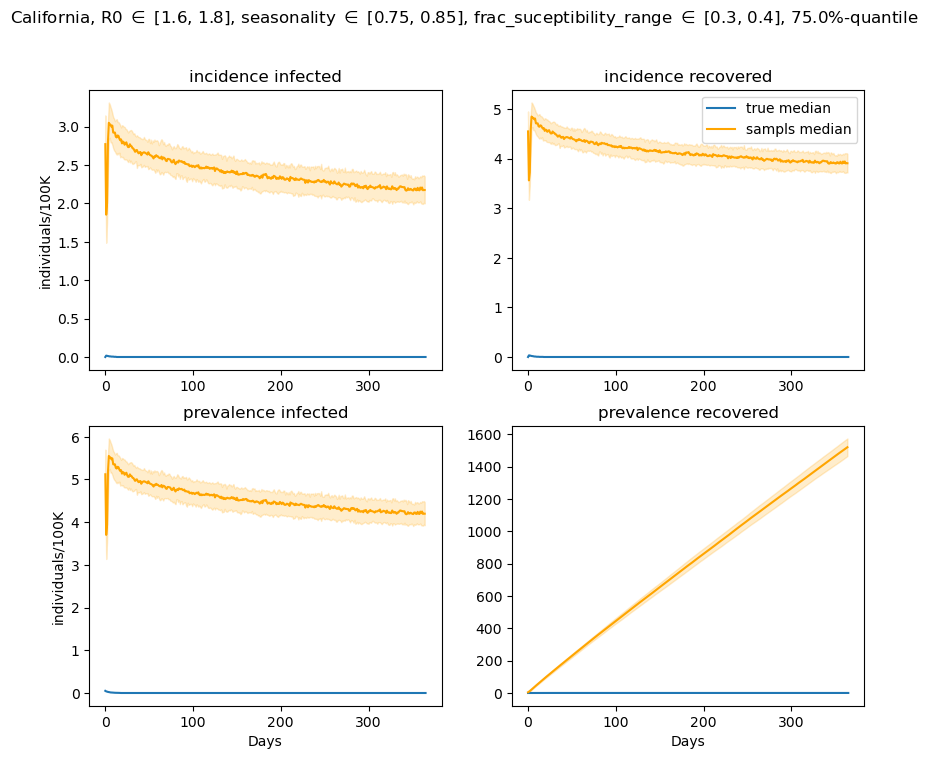

In [87]:
quantiles=[.25, .75]
plot_results(inc_infected_data, inc_recovered_data, prev_infected_data, prev_recovered_data, inc_infected_samples, inc_recovered_samples, prev_infected_samples, prev_recovered_samples, quantiles)
_=plt.suptitle(f"{id2states[state_id]}, R0 $\in$ {r0_range}, seasonality $\in$ {seasonality_range}, frac_suceptibility_range $\in$ {frac_suceptibility_range}, {quantiles[-1]*100}%-quantile")
plt.savefig("./figs/quantile_4.jpg", dpi=300)

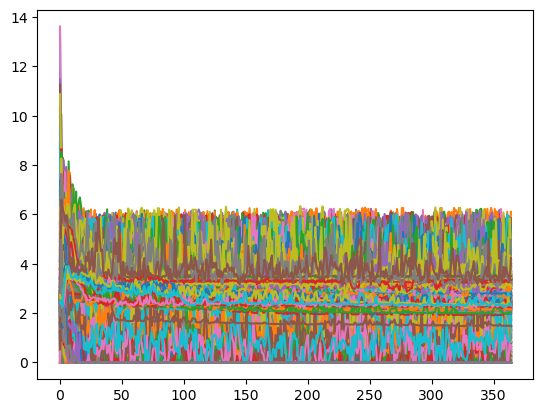

In [97]:
_=plt.plot(inc_infected_samples.T)

In [61]:
fid=75
x_filename, y_inc_filename, y_prev_filename=x_files[fid], inc_files[fid], prev_files[fid]
x= np.load(x_filename)
y_inc= np.load(y_inc_filename)
y_prev= np.load(y_prev_filename)

y= np.concatenate([y_inc, y_prev], axis=-1)

In [62]:
samples= model.get_samples(x, y[:, 0, ...], stats)

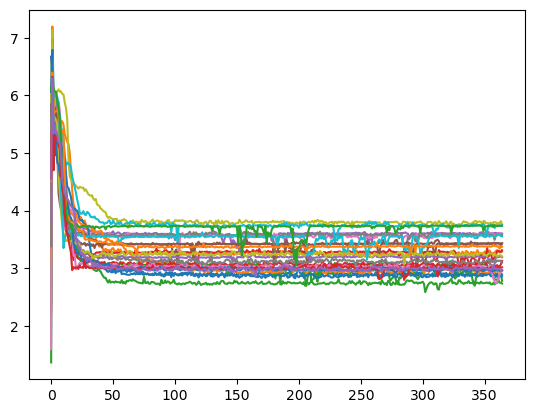

In [63]:
_=plt.plot(samples[..., 4].T)


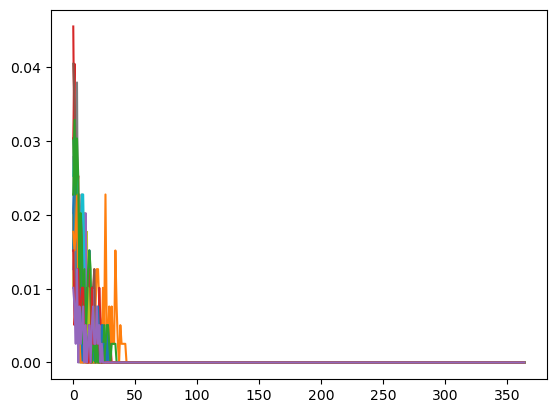

In [64]:
_=plt.plot(y[:, 1:, 4].T)

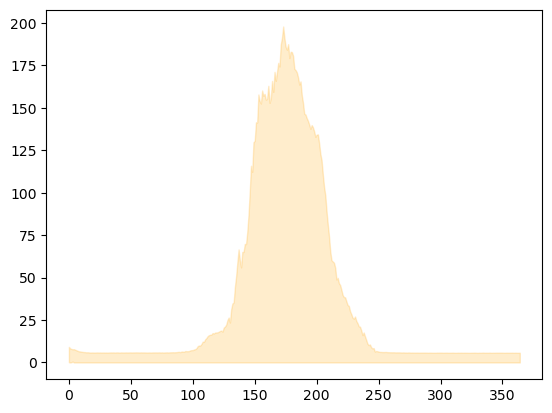

In [81]:
 q05, q95= np.quantile(inc_infected_samples, axis=0, q=[.025, .975])
_= plt.fill_between(x= range(inc_infected_samples.shape[1]), y1=q05, y2= q95, alpha=.2, color="orange")